**Lending Club - Data Story**

The objective of this notebook is to understand the trends of interesting feature in Lending Club data. 
The key questions I would like to ask are:
 1. What is the percentage of bad loan (default) in this data?
 2. Which states have higher amound of loan issue?
 3. Which states have higher percentage of bad loan status?
 4. Which attributes are related to the risk of borrower defaults on his/her loan?
 5. Are those data valuable for investors when they select loans to invest in?
 6. Can we estimate the average return an investor expect from the p2p loan?

##  Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time
from scipy.stats import shapiro
import statsmodels.api as sm
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Preprocessing
### Import Data
Load Lending data 2012-2019

In [2]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'data_2012_2019_rm.csv', low_memory=False, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'] )
end = time.time()
print('It takes  ' + str(round((end-start)/60,1)) +' min to read the data')

It takes  14.8 min to read the data


In [3]:
# show missing data
(df.isnull().sum()[df.isnull().sum() >0]/len(df)*100).sort_values(ascending=False)

mths_since_recent_inq    11.503325
emp_length                7.012418
num_tl_120dpd_2m          4.322716
mo_sin_old_il_acct        4.035890
bc_util                   1.375966
                           ...    
mort_acc                  0.273494
total_bal_ex_mort         0.273494
total_bc_limit            0.273494
dti                       0.104057
inq_last_6mths            0.000037
Length: 38, dtype: float64

### Features

In [4]:
df.head()

issue_d earliest_cr_line last_pymnt_d last_credit_pull_d  \
id                                                                     
10224583 2013-12-01       2001-06-01   2016-02-01         2018-06-01   
10148122 2013-12-01       2003-09-01   2016-06-01         2020-01-01   
10149342 2013-12-01       1986-10-01   2016-07-01         2018-03-01   
10129454 2013-12-01       2009-12-01   2016-04-01         2018-08-01   
10149488 2013-12-01       1995-08-01   2014-09-01         2017-01-01   

          int_rate  revol_util loan_status home_ownership sub_grade  \
id                                                                    
10224583     14.98        66.2  Fully Paid       MORTGAGE        C3   
10148122      7.62        55.7  Fully Paid       MORTGAGE        A3   
10149342     10.99        61.2  Fully Paid            OWN        B2   
10129454     10.99        24.0  Fully Paid           RENT        B2   
10149488     10.99        16.1  Fully Paid       MORTGAGE        B2   

         debt_settlement_flag grade application_type             purpose  \
id                                                                         
10224583                    N     C       Individual               other   
10148122                    N     A       Individual  debt_consolidation   
10149342                    N     B       Individual  debt_consolidation   
10129454                    N     B       Individual  debt_consolidation   
10149488                    N     B       Individual    home_improvement   

         initial_list_status hardship_flag  \
id                                           
10224583                   f             N   
10148122                   f             N   
10149342                   w             N   
10129454                   f             N   
10149488                   w             N   

                                           title emp_length pymnt_plan  \
id                                                                       
10224583                                   Other  10+ years          n   
10148122  Debt Consolidation and Credit Transfer    3 years          n   
10149342                      Debt Consolidation  10+ years          n   
10129454                              No Regrets    4 years          n   
10149488                           For The House    2 years          n   

         verification_status addr_state        term  loan_amnt  funded_amnt  \
id                                                                            
10224583        Not Verified         NY   36 months    11100.0      11100.0   
10148122        Not Verified         TX   36 months    12000.0      12000.0   
10149342            Verified         MI   36 months    27050.0      27050.0   
10129454        Not Verified         NC   36 months    12000.0      12000.0   
10149488     Source Verified         TX   36 months     4800.0       4800.0   

          funded_amnt_inv  int_rate.1  ...  mort_acc  mths_since_recent_bc  \
id                                     ...                                   
10224583          11100.0       14.98  ...       1.0                  11.0   
10148122          12000.0        7.62  ...       1.0                  10.0   
10149342          27050.0       10.99  ...       4.0                  16.0   
10129454          12000.0       10.99  ...       0.0                   1.0   
10149488           4800.0       10.99  ...       0.0                  25.0   

          mths_since_recent_inq  num_accts_ever_120_pd  num_actv_bc_tl  \
id                                                                       
10224583                   11.0                    1.0             4.0   
10148122                   10.0                    0.0             4.0   
10149342                    8.0                    0.0             2.0   
10129454                    3.0                    0.0             4.0   
10149488                    3.0                    0.0             2.0   

          num_

In [5]:
df.select_dtypes('object').columns

Index(['loan_status', 'home_ownership', 'sub_grade', 'debt_settlement_flag',
       'grade', 'application_type', 'purpose', 'initial_list_status',
       'hardship_flag', 'title', 'emp_length', 'pymnt_plan',
       'verification_status', 'addr_state', 'term'],
      dtype='object')

In [6]:
df.select_dtypes('float').columns

Index(['int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate.1', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util.1', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl

In [7]:
df.select_dtypes('datetime').columns

Index(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], dtype='object')

##  Exploratory Data Analysis
### Loan Status

- The question we can ask is what is the amount of bad loans Lending Club has declared so far? However, we have to understand there are still current loans that will be paid off or defaulting in the future.
- The amount of good or bad loans can change as the days pass by, since we still have a great amount of current loans.
- We will have to take a look at time-series data to look at the trend of each loan status.

#### Loan Status

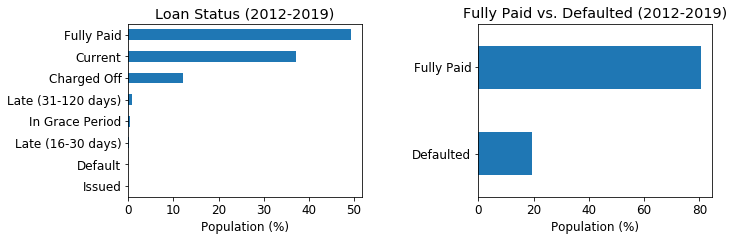

In [30]:
# Look at loan status (2012-2019)
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,2, figsize=(12,3))

(df['loan_status'].value_counts(normalize=True)*100).sort_values().plot.barh(ax=ax[0])
ax[0].set_xlabel('Population (%)')
ax[0].set_title('Loan Status (2012-2019)')

(df.query("loan_status in ['Fully Paid', 'Charged Off']")['loan_status'].value_counts(normalize=True)*100)\
.sort_values().plot.barh(ax=ax[1])
ax[1].set_xlabel('Population (%)')
ax[1].set_title('Fully Paid vs. Defaulted (2012-2019)')
y_tick_labels = ['Defaulted','Fully Paid']
ax[1].set_yticklabels(y_tick_labels)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, wspace = 0.5)

In [11]:
df['loan_status'].value_counts(normalize=True)

Fully Paid            0.493229
Current               0.372801
Charged Off           0.120026
Late (31-120 days)    0.008292
In Grace Period       0.003939
Late (16-30 days)     0.001692
Default               0.000018
Issued                0.000004
Name: loan_status, dtype: float64

**Insights**
- The data is imbalanced. Fully Paid is 80%, whereas Charged off is 20%.
- In the loan status, there is still 37% current loan that has not been expired.

#### Default Rate

In [12]:
df_time = df[['issue_d','loan_status','term','loan_amnt']]
df_time.set_index('issue_d',inplace=True)

<Figure size 1800x360 with 0 Axes>

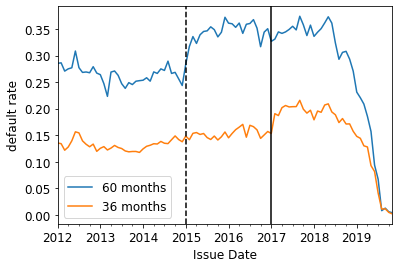

In [13]:
# default rate over years
plt.figure(figsize=(25,5)) 

plt.rcParams.update({'font.size': 12})
df_time_default_60m = df_time.query("loan_status in ['Fully Paid', 'Charged Off'] & term == ' 60 months'")\
.groupby('issue_d')['loan_status'].value_counts(normalize=True).to_frame()
df_time_default_60m.rename(columns={'loan_status':'60 months'}, inplace=True)
df_time_default_60m.reset_index(level=1,inplace=True)
ax = df_time_default_60m.query(" loan_status == 'Charged Off' ").plot(label='60 months') #.rolling(1).mean()

df_time_default_36m = df_time.query("loan_status in ['Fully Paid', 'Charged Off'] & term == ' 36 months'")\
.groupby('issue_d')['loan_status'].value_counts(normalize=True).to_frame()
df_time_default_36m.rename(columns={'loan_status':'36 months'}, inplace=True)
df_time_default_36m.reset_index(level=1,inplace=True)
df_time_default_36m.query(" loan_status == 'Charged Off' ").plot(label='36 months', ax=ax)

ax.axvline("2017-01-01", color="black", linestyle="-")
ax.axvline("2015-01-01", color="black", linestyle="--")

plt.xlabel('Issue Date')
plt.ylabel('default rate')
plt.legend()
plt.show()

**Insights**
- Overall, 60 month loan has a higher default rate than the 36 month loan.
- The status of later loans (defautled or non-defaulted) is still unknown. That's why the default rate drops after 2017.
- Because the minimum maturity of 36-month loan is 36 months, we can only analyze the data until 2017. Similarly, for 60-month loan, we can only analyze the data until 2015.

**Hypothesis**

There is a clear drop of default rate after 2018. My hypothesis is that most loans issued after 2018 does not enought time to default yet. There might be some loan repaid early, before the end of the loan term.

#### Loan Amount

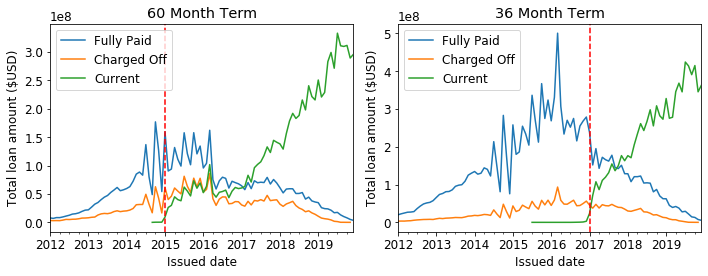

In [34]:
fig, ax = plt.subplots(1,2, figsize=(10,4)) 

plt.rcParams.update({'font.size': 12})

df_time.query(" loan_status == 'Fully Paid' & term == ' 60 months' ")['loan_amnt']\
    .resample('M').sum().rolling(1).mean().plot(label='Fully Paid', ax=ax[0]) #
df_time.query(" loan_status == 'Charged Off' & term == ' 60 months' ")['loan_amnt']\
    .resample('M').sum().rolling(1).mean().plot(label='Charged Off', ax=ax[0])
df_time.query(" loan_status == 'Current' & term == ' 60 months' ")['loan_amnt']\
    .resample('M').sum().rolling(1).mean().plot(label='Current', ax=ax[0])

ax[0].axvline("2015-01-01", color="red", linestyle="--")
ax[0].legend()
ax[0].set_ylabel('Total loan amount ($USD)')
ax[0].set_xlabel('Issued date')
ax[0].set_title('60 Month Term')

df_time.query(" loan_status == 'Fully Paid' & term == ' 36 months' ")['loan_amnt']\
    .resample('M').sum().rolling(1).mean().plot(label='Fully Paid', ax=ax[1])
df_time.query(" loan_status == 'Charged Off' & term == ' 36 months' ")['loan_amnt']\
    .resample('M').sum().rolling(1).mean().plot(label='Charged Off', ax=ax[1])
df_time.query(" loan_status == 'Current' & term == ' 36 months' ")['loan_amnt']\
    .resample('M').sum().rolling(1).mean().plot(label='Current', ax=ax[1])

ax[1].axvline("2017-01-01", color="red", linestyle="--")
ax[1].legend()
ax[1].set_ylabel('Total loan amount ($USD)')
ax[1].set_xlabel('Issued date')
ax[1].set_title('36 Month Term')
plt.tight_layout()

**Insights**

- Total loan amount keeps increases for current loan, suggesting it is still on-going and is not expired.
- More loans were paid off for 36 month term.
- More loans were charged off for 60 month term.

### Calculate loan period
calcluate the time period of the loan for each borrower
- `last payment date` minus `loan issue date`

In [18]:
# only select either 'Fully Paid' or 'Charged Off' for Target
df_fc = df.query("loan_status in ['Fully Paid', 'Charged Off'] ")
df_fc.shape

(1674326, 90)

In [19]:
df_fc['loan_period'] = (df_fc['last_pymnt_d'] - df_fc['issue_d']) / np.timedelta64(1, 'M')

In [20]:
# remove loan_period = 0
df_fc = df_fc[df_fc['loan_period']!=0]

In [21]:
# check distribution for binary classification
df_fc['loan_status'].value_counts(normalize=True)

Fully Paid     0.80284
Charged Off    0.19716
Name: loan_status, dtype: float64

In [22]:
# fully paid: 0, charged off:1
df_fc['target'] = df_fc['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1)
df_fc['target'].value_counts(normalize=True) 

0    0.80284
1    0.19716
Name: target, dtype: float64

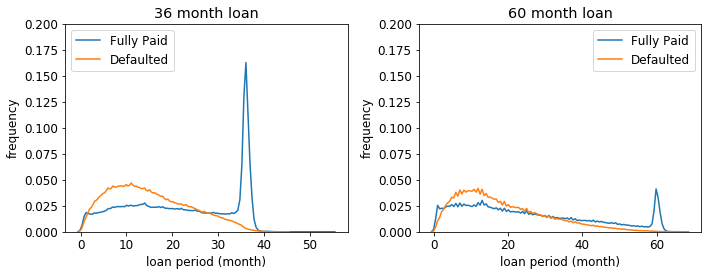

In [49]:
# compare loan period for 36 month vs 60 month loan

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10,4))
plt.rcParams.update({'font.size': 12})
sns.distplot(df_fc[(df_fc['target']==0) & (df_fc['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=30, rug=False, label = 'Fully Paid', kde_kws= {"bw":0.5}, ax=ax1)
sns.distplot(df_fc[(df_fc['target']==1) & (df_fc['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=30,rug=False, label = 'Defaulted', kde_kws= {"bw":0.5}, ax=ax1)

ax1.set_title('36 month loan')
ax1.set_xlabel('loan period (month)')
ax1.set_ylabel('frequency')
ax1.set_ylim([0, 0.2])
#ax1.set_xlim([0, 36])

sns.distplot(df_fc[(df_fc['target']==0) & (df_fc['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=30,rug=False, label = 'Fully Paid', kde_kws= {"bw":0.5}, ax=ax2)
sns.distplot(df_fc[(df_fc['target']==1) & (df_fc['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=30,rug=False, label = 'Defaulted', kde_kws= {"bw":0.5}, ax=ax2)

ax2.set_title('60 month loan')
ax2.set_xlabel('loan period (month)')
ax2.set_ylabel('frequency')
ax2.set_ylim([0, 0.2])
plt.tight_layout()

**Insights**
- Borrowers with 36 month term tend to paid off their loan at the very end of the term. 
- For Borrowers who has 60 month term and no default, they usually paid off their loan before the term expired. 
- Borrowers who charged off their loan usually happened in their 10 month loan period.

In [36]:
a =len(df_fc.query(" target ==0 & term == ' 36 months' & loan_period <= 35 "))
b= len(df_fc.query(" target ==0 & term == ' 36 months' & loan_period > 35 "))

print("The borrowers who paid of their 36 months loan, " + str(round(a/(a+b)*100, 2))+ " % paid off before the loan expired")


c =len(df_fc.query(" target ==0 & term == ' 60 months' & loan_period <= 59 "))
d= len(df_fc.query(" target ==0 & term == ' 60 months' & loan_period > 59 "))

print("The borrowers who paid of their 60 months loan, " + str(round(c/(c+d)*100, 2))+ " % paid off before the loan expired")


The borrowers who paid of their 36 months loan, 73.82 % paid off before the loan expired
The borrowers who paid of their 60 months loan, 93.13 % paid off before the loan expired


Next, we look at the loan period after 2017.

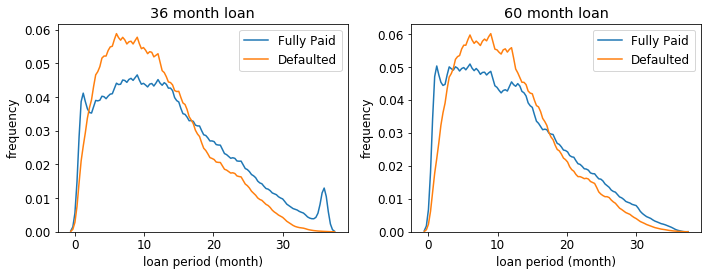

In [50]:
# Take a look at loan period after 2018
df_after2018 = df_fc[df_fc['issue_d'].dt.year.isin([2017, 2018, 2019])]
plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10,4))

sns.distplot(df_after2018[(df_after2018['target']==0) & (df_after2018['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=100, rug=False, label = 'Fully Paid', kde_kws= {"bw":0.5}, ax=ax1)
sns.distplot(df_after2018[(df_after2018['target']==1) & (df_after2018['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=100,rug=False, label = 'Defaulted', kde_kws= {"bw":0.5},ax=ax1)

ax1.set_title('36 month loan')
ax1.set_xlabel('loan period (month)')
ax1.set_ylabel('frequency')


sns.distplot(df_after2018[(df_after2018['target']==0) & (df_after2018['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=100,rug=False, label = 'Fully Paid', kde_kws= {"bw":0.5}, ax=ax2)
sns.distplot(df_after2018[(df_after2018['target']==1) & (df_after2018['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=100,rug=False, label = 'Defaulted', kde_kws= {"bw":0.5}, ax=ax2)

ax2.set_title('60 month loan')
ax2.set_xlabel('loan period (month)')
ax2.set_ylabel('frequency')
plt.tight_layout()

The distributions are quite similar. It looks like the loan is still ungoing.


### Return

In [39]:
df_fc['term_num'] = df_fc['term'].str.extract('(\d+)',expand=False).astype(int)
#df['term_num'].head(2)

In [40]:
df_fc['return_1'] = ( (df_fc['total_pymnt'] - df_fc['funded_amnt'] )
                                            / df_fc['funded_amnt'] ) * (12 / df_fc['loan_period'])

df_fc['return_2'] = ( (df_fc['total_pymnt'] - df_fc['funded_amnt'] )
                                            / df_fc['funded_amnt'] ) * (12 / df_fc['term_num'])

df_fc['return_3'] = df_fc['return_1'].copy()

In [41]:
df_fc.loc[df_fc['return_3']<0, 'return_3']= df_fc[df_fc['return_1']<0]['return_2']

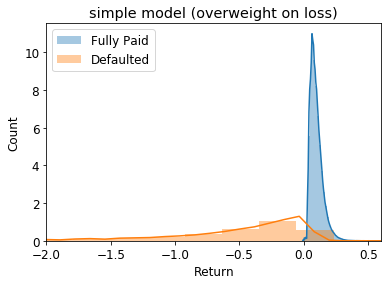

In [110]:
# return 1
#fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,5))
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 12})
sns.distplot(df_fc[(df_fc['target']==0)]['return_1'], hist=True, \
             bins=50, rug=False, label = 'Fully Paid', kde=True)
sns.distplot(df_fc[(df_fc['target']==1)]['return_1'], hist=True, \
             bins=50,rug=False, label = 'Defaulted', kde=True)
plt.legend()
#plt.title('60 month loan')
plt.xlabel('Return')
plt.ylabel('Count')
plt.title('simple model (overweight on loss)')
plt.xlim([-2,0.6])
plt.show()

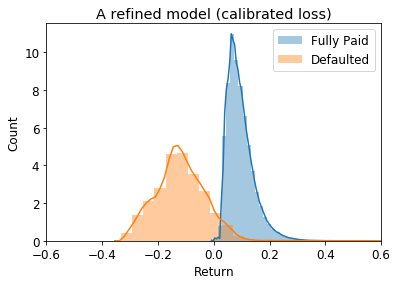

In [111]:
# return 3
#fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,5))
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 12})
sns.distplot(df_fc[(df_fc['target']==0)]['return_3'], hist=True, \
             bins=50, rug=False, label = 'Fully Paid', kde=True)
sns.distplot(df_fc[(df_fc['target']==1)]['return_3'], hist=True, \
             bins=50,rug=False, label = 'Defaulted', kde=True)
plt.legend()
#plt.title('60 month loan')
plt.xlabel('Return')
plt.ylabel('Count')
plt.title('A refined model (calibrated loss)')
plt.xlim([-0.6,0.6])
plt.show()

In [64]:
df_fc[(df_fc['target']==0)]['return_3'].describe()

count    1.334303e+06
mean     9.576414e-02
std      4.803483e-02
min      0.000000e+00
25%      6.171102e-02
50%      8.593310e-02
75%      1.193452e-01
max      7.375954e-01
Name: return_3, dtype: float64

In [65]:
df_fc[(df_fc['target']==1)]['return_3'].describe()

count    327675.000000
mean         -0.120561
std           0.087731
min          -0.333083
25%          -0.177778
50%          -0.123039
75%          -0.062703
max           1.675665
Name: return_3, dtype: float64

## Loan Issued by States

In [85]:
states = df_fc['addr_state'].unique()
print(states)
print(len(states))

['NY' 'TX' 'MI' 'NC' 'CT' 'FL' 'CA' 'CO' 'NM' 'MA' 'NJ' 'PA' 'UT' 'SC'
 'OH' 'IN' 'AZ' 'DE' 'KY' 'GA' 'WI' 'IL' 'MO' 'WY' 'TN' 'WA' 'MD' 'VA'
 'MN' 'NH' 'NV' 'KS' 'AL' 'RI' 'OR' 'WV' 'LA' 'VT' 'AR' 'OK' 'HI' 'MT'
 'AK' 'SD' 'DC' 'NE' 'MS' 'ID' 'ME' 'ND']
50


In [67]:
# Look at IA State
df.query("addr_state == 'IA'").head()

issue_d earliest_cr_line last_pymnt_d last_credit_pull_d  \
id                                                                     
7705836  2013-10-01       2008-03-01   2015-06-01         2016-10-01   
13006761 2014-03-01       2006-01-01   2016-09-01         2016-10-01   

          int_rate  revol_util  loan_status home_ownership sub_grade  \
id                                                                     
7705836      15.61        69.1  Charged Off       MORTGAGE        C3   
13006761     15.61        38.5   Fully Paid           RENT        C5   

         debt_settlement_flag grade application_type             purpose  \
id                                                                         
7705836                     N     C       Individual  debt_consolidation   
13006761                    N     C       Individual                 car   

         initial_list_status hardship_flag               title emp_length  \
id                                                                          
7705836                    f             N  debt consolidation   < 1 year   
13006761                   w             N       Car financing     1 year   

         pymnt_plan verification_status addr_state        term  loan_amnt  \
id                                                                          
7705836           n        Not Verified         IA   36 months     7200.0   
13006761          n     Source Verified         IA   36 months     6725.0   

          funded_amnt  funded_amnt_inv  int_rate.1  ...  mort_acc  \
id                                                  ...             
7705836        7200.0           7200.0       15.61  ...       0.0   
13006761       6725.0           6725.0       15.61  ...       0.0   

          mths_since_recent_bc  mths_since_recent_inq  num_accts_ever_120_pd  \
id                                                                             
7705836                    NaN                   16.0                    0.0   
13006761                  25.0                   10.0                    1.0   

          num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  \
id                                                                             
7705836              0.0              3.0          0.0        0.0        6.0   
13006761             4.0              4.0          4.0        6.0        3.0   

          num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  \
id                                                                      
7705836             3.0            6.0                  3.0       6.0   
13006761            6.0            9.0                  4.0       7.0   

          num_tl_120dpd_2m  num_tl_30dpd  num_tl_90g_dpd_24m  \
id                                                             
7705836                0.0           0.0                 0.0   
13006761               0.0           0.0                 0.0   

          num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  \
id                                                               
7705836                  1.0           100.0               NaN   
13006761                 2.0            76.9              50.0   

          pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
id                                                                              
7705836                    0.0        0.0          49146.0            34037.0   
13006761                   0.0        0.0          21883.0            15134.0   

          total_bc_limit  total_il_high_credit_limit  
id                                                    
7705836              0.0                     29146.0  
13006761          2900.0                     16483.0  

[2 rows x 90 columns]

IA has the highest default rate, but it only has two data points. We have to remove this, because it is an outlier. In fact, according to the updated [Lending club website](https://blog.lendingclub.com/is-lending-club-available-in-my-state/), LC does not accept borrower resident in Iowa.

In [68]:
# remove IA from addr_state
df_fc = df_fc[df_fc['addr_state'] != 'IA']

Next, we seperate states into different regions according to [Census Bureau](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States).


In [69]:
# Make a list with each of the regions by state.

northeast = ['CT','ME','MA','NH','RI','VT','NJ','NY','PA']
midwest = ['IL','IN','MI','OH','WI','IA','KS','MN','MO','NE','ND','SD']
south = ['DE','FL','GA','AZ','MD','NC','SC','VA','DC','WV','AL','KY','MS','TN','AR','LA','OK','TX']
west = ['CO','ID','MT','NV','NM','UT','WY','AK','CA','HI','OR','WA']
states_all = northeast + midwest + south + west
assert len(states_all) == 51

In [70]:
# find out which state is missing
states_rm = df_fc['addr_state'].unique()
set(states_all).difference(set(states_rm))

{'IA'}

In [71]:
# add region column
df_fc['region'] = np.nan

def finding_regions(state):
    if state in northeast:
        return 'northeast'
    elif state in midwest:
        return 'midwest'
    elif state in south:
        return 'south'
    elif state in west:
        return 'west'
    
df_fc['region'] = df_fc['addr_state'].apply(finding_regions)

In [72]:
df_state_loan_amnt = df_fc.groupby(['region','addr_state'])['loan_amnt'].sum().sort_values(ascending=False).to_frame().reset_index()
df_state_income = df_fc.groupby(['region','addr_state'])['annual_inc'].median().sort_values(ascending=False).to_frame().reset_index()
df_state_int = df_fc.groupby(['region','addr_state'])['int_rate'].median().sort_values(ascending=False).to_frame().reset_index()

df_target = df_fc.groupby(['region','addr_state'])['target'].value_counts(normalize=True).to_frame()
df_target = df_target.iloc[df_target.index.get_level_values('target') == 1]\
    .rename(columns={"target": "default_rate"}).reset_index().sort_values(by=["default_rate"], ascending=False)

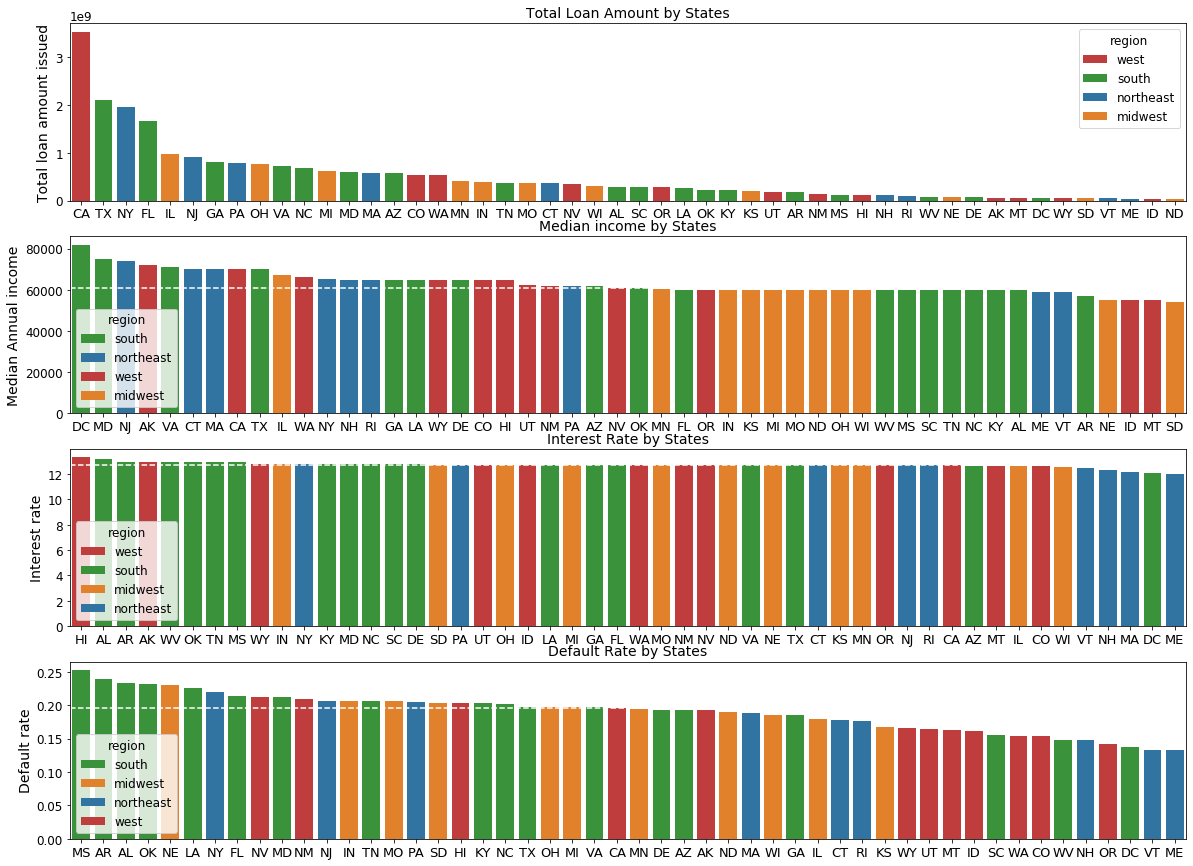

In [73]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False, figsize=(20,15))

palette ={"northeast":"C0","midwest":"C1","south":"C2", "west":"C3"}

sns.barplot('addr_state', 'loan_amnt', hue='region', dodge=False, \
            data=df_state_loan_amnt,ax=ax1, palette=palette)
ax1.set_title('Total Loan Amount by States',fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Total loan amount issued', fontsize=14)

sns.barplot('addr_state', 'annual_inc', hue='region',dodge=False, \
            data=df_state_income, ax=ax2, palette=palette) 
ax2.set_title('Median income by States',fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Median Annual income', fontsize=14)
median_ic= np.median(df_state_income['annual_inc'])
ax2.axhline(y=median_ic, color="white",linestyle="--")

sns.barplot('addr_state', 'int_rate', hue='region',dodge=False, \
            data=df_state_int, ax=ax3,palette=palette)
ax3.set_title('Interest Rate by States',fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Interest rate', fontsize=14)
median_ir= np.median(df_state_int['int_rate'])
ax3.axhline(y=median_ir, color="white",linestyle="--")

sns.barplot('addr_state', 'default_rate', hue='region',dodge=False, \
            data=df_target, ax=ax4,palette=palette)
ax4.set_title('Default Rate by States',fontsize=14)
ax4.set_xlabel('')
ax4.set_ylabel('Default rate', fontsize=14)
median_dr= np.median(df_target['default_rate'])
ax4.axhline(y=median_dr, color="white",linestyle="--")

# adjust font size
for ax in (ax1, ax2, ax3, ax4):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(13)

In [74]:
df_region_loan_amnt = df_fc.groupby(['region'])['loan_amnt'].sum().sort_values(ascending=False).to_frame().reset_index()
df_region_income = df_fc.groupby(['region'])['annual_inc'].median().sort_values(ascending=False).to_frame().reset_index()
df_region_int = df_fc.groupby(['region'])['int_rate'].median().sort_values(ascending=False).to_frame().reset_index()

df_region_target = df_fc.groupby(['region'])['target'].value_counts(normalize=True).to_frame()
df_region_target = df_region_target.iloc[df_region_target.index.get_level_values('target') == 1]\
    .rename(columns={"target": "default_rate"}).reset_index().sort_values(by=["default_rate"], ascending=False)

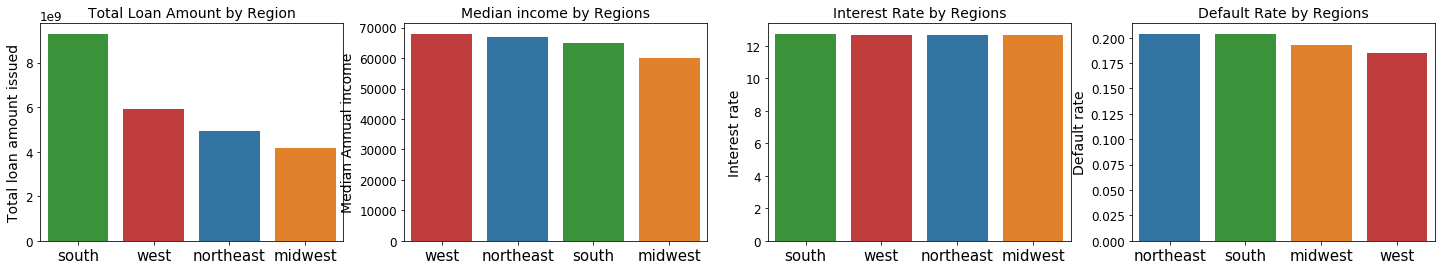

In [75]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=False, figsize=(25,4))

palette ={"northeast":"C0","midwest":"C1","south":"C2", "west":"C3"}

sns.barplot(x='region', y='loan_amnt', data=df_region_loan_amnt, ax=ax1, palette=palette)
ax1.set_title('Total Loan Amount by Region',fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Total loan amount issued', fontsize=14)

sns.barplot('region', 'annual_inc', data=df_region_income, ax=ax2, palette=palette) 
ax2.set_title('Median income by Regions',fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Median Annual income', fontsize=14)

sns.barplot('region', 'int_rate', data=df_region_int , ax=ax3,palette=palette)
ax3.set_title('Interest Rate by Regions',fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Interest rate', fontsize=14)

sns.barplot('region', 'default_rate', data=df_region_target , ax=ax4,palette=palette)
ax4.set_title('Default Rate by Regions',fontsize=14)
ax4.set_xlabel('')
ax4.set_ylabel('Default rate', fontsize=14)

# adjust font size
for ax in (ax1, ax2, ax3, ax4):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

### Loan Amount 

In [76]:
# join dataframes
df_join = pd.merge(df_state_loan_amnt[['addr_state','loan_amnt']],
                    df_state_income[['addr_state', 'annual_inc']],
                    on='addr_state', how='inner')

df_join = pd.merge(df_join, df_state_int[['addr_state', 'int_rate']],on='addr_state', how='inner')

In [77]:
df_join = df_join.rename(columns={'addr_state':'state', 'loan_amnt':'loan_amount', 'annual_inc': 'income'})
df_join.head() 

state   loan_amount   income  int_rate
0    CA  3.526288e+09  70000.0     12.69
1    TX  2.096008e+09  70000.0     12.69
2    NY  1.953070e+09  65500.0     12.79
3    FL  1.663743e+09  60000.0     12.74
4    IL  9.679798e+08  67200.0     12.62

In [78]:
# Plot plotly United States map
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.offline as po
po.init_notebook_mode()

df_map1=df_join.copy()

# convert to values to string
for col in df_map1.columns:
    df_map1[col] = df_map1[col].astype(str)
    
df_map1['text'] = df_map1['state'] + '<br>' +\
'Median interest rate: ' + df_map1['int_rate'] + ' %' +'<br>'+\
'Median annual income: ' + df_map1['income'] 


fig = go.Figure(data=go.Choropleth(
    locations=df_map1['state'],
    z=df_map1['loan_amount'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=df_map1['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="$ USD"
))

fig.update_layout(
    title_text='US Loan Amount by State<br>(2012-2019)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

In [87]:
img_bytes = fig.to_image(format="png")

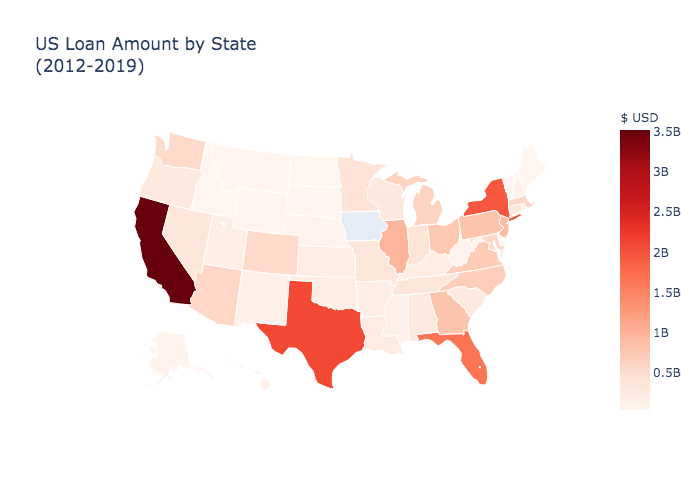

In [88]:
from IPython.display import Image
Image(img_bytes)

**Insights**
- California (CA), Texas (TX), and New York (NY) are the top-3 states with highest amount of loans issued between 2012-2019.
- The median annual income in CA, TX, and NY are all above median national income value. It may be why these three states have the highest loan amount.
- South and west regions have higher loan amount than the northest and midest regions.
- Median value of interest rates are very simular amount the states.

### Default rate

In [89]:
df_fc['fico'] = (df_fc['fico_range_high']+df_fc['fico_range_low'])/2
df_fc['fico'].mean()

698.6942016611551

In [90]:
df_fc['emp_length'].unique()

array(['10+ years', '3 years', '4 years', '2 years', '5 years', '6 years',
       '1 year', '7 years', '8 years', '< 1 year', '9 years', nan],
      dtype=object)

In [91]:
def finding_emp_length(emp_length):
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '1 year':
        return 1
    elif emp_length == '2 years':
        return 2
    elif emp_length == '3 years':
        return 3
    elif emp_length == '4 years':
        return 4
    elif emp_length == '5 years':
        return 5
    elif emp_length == '6 years':
        return 6
    elif emp_length == '7 years':
        return 7
    elif emp_length == '8 years':
        return 8
    elif emp_length == '9 years':
        return 9
    elif emp_length == '10+ years':
        return 10

    
df_fc['emp_length_num'] = df_fc['emp_length'].apply(finding_emp_length)

In [92]:
df_state_emp_length_num = df_fc.groupby(['region','addr_state'])['emp_length_num'].median().sort_values(ascending=False).to_frame().reset_index()
df_state_fico = df_fc.groupby(['region','addr_state'])['fico'].median().sort_values(ascending=False).to_frame().reset_index()
df_state_dti = df_fc.groupby(['region','addr_state'])['dti'].median().sort_values(ascending=False).to_frame().reset_index()

In [93]:
# join dataframes
df_join_2 = pd.merge(df_state_emp_length_num[['addr_state','emp_length_num']],
                    df_state_fico[['addr_state', 'fico']],
                     on='addr_state', how='inner')

df_join_2 = pd.merge(df_join_2, df_state_dti[['addr_state', 'dti']],on='addr_state', how='inner')
df_join_2 = pd.merge(df_join_2, df_target[['addr_state', 'default_rate']],on='addr_state', how='inner')

In [94]:
df_join_2 = df_join_2.rename(columns={'addr_state':'state', 'emp_length_num':'employee_length'})
df_join_2.head()

state  employee_length   fico    dti  default_rate
0    HI              8.0  687.0  18.93      0.203165
1    DE              7.0  692.0  18.61      0.193336
2    WI              7.0  692.0  18.90      0.185844
3    VT              7.0  692.0  19.71      0.133643
4    RI              7.0  692.0  17.03      0.176221

In [105]:
# Plot plotly United States map
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.offline as po
po.init_notebook_mode()

df_map2=df_join_2.copy()

# convert to values to string
for col in df_map2.columns:
    df_map2[col] = df_map2[col].astype(str)
    
df_map2['text'] = df_map2['state'] + '<br>' +\
'Median Credit Scores: ' + df_map2['fico'] +'<br>'+\
'Median Debit-to-income: ' + df_map2['dti'] +'<br>'+\
'Median Employee Length: ' + df_map2['employee_length'] +' years'


fig = go.Figure(data=go.Choropleth(
    locations=df_map2['state'],
    z=df_map2['default_rate'].astype(float),
    locationmode='USA-states',
    colorscale='Blues',
    autocolorscale=False,
    text=df_map2['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Default Rate"
))

fig.update_layout(
    title_text='US Default Rate by State<br>(2012-2019)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

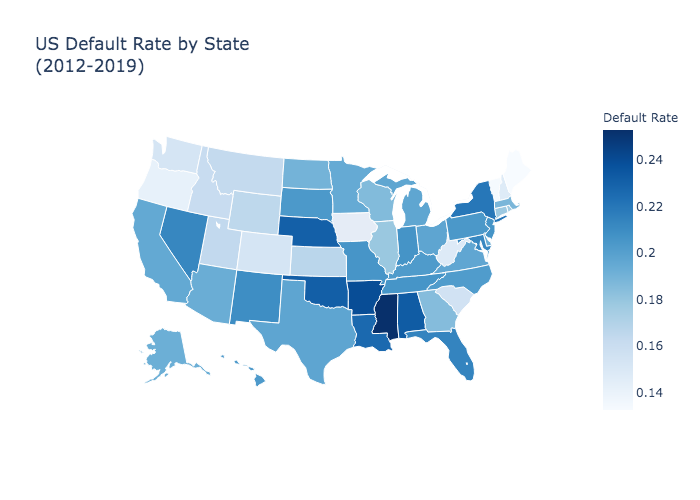

In [106]:
img_bytes = fig.to_image(format="png")
from IPython.display import Image
Image(img_bytes)

**Insights**
- Mississippi (MS), Arkansas (AR), and Alabama (AL) are the top-3 states with highest default rate issued between 2012-2019. They are all int the South.
- The median debit-to-income ratio in MS, AR, and AL are all above median national income value. It may be why these three states have the highest default rate.
- Northest and south have higher loan amount than the west and midest regions.

## Credit

Text(0.5, 0, 'grade')

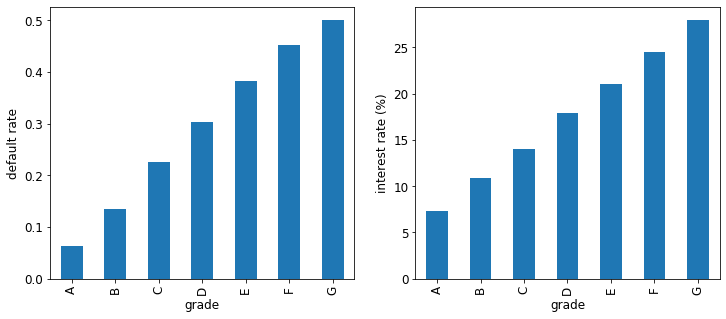

In [97]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
(df_fc.groupby('grade')['target'].sum()/df_fc.groupby('grade')['target'].count()).plot.bar(ax=ax[0])
ax[0].set_ylabel('default rate')
ax[0].set_xlabel('grade')

(df_fc.groupby('grade')['int_rate'].median()).plot.bar(ax=ax[1])
ax[1].set_ylabel('interest rate (%)')
ax[1].set_xlabel('grade')

**Insights**
- The scores has a lower grade has higher level of risk to default.
- The lower the grader, the higher the interest rate the borrower has to pay to investors.


In [98]:
df_fc.to_csv('data_eda.csv')

## Correlation

In [99]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df_CO = pd.read_csv(path+'LC_ML_prep.csv', low_memory=False, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d'] )
end = time.time()
print('It takes  ' + str(round((end-start)/60,1)) +' min to read the data')

It takes  0.3 min to read the data


In [100]:
df_CO.shape

(1132216, 26)

In [101]:
df_CO.head()

home_ownership verification_status             purpose addr_state  pub_rec  \
1       MORTGAGE        Not Verified  debt_consolidation         TX      0.0   
2            OWN            Verified  debt_consolidation         MI      0.0   
3           RENT        Not Verified  debt_consolidation         NC      0.0   
5       MORTGAGE        Not Verified  debt_consolidation         CT      0.0   
6           RENT        Not Verified  debt_consolidation         NC      1.0   

   term_num  grade_num  loan_period  int_rate  revol_util  loan_amnt  \
1        36          1    29.996509      7.62        55.7    12000.0   
2        36          2    30.982156     10.99        61.2    27050.0   
3        36          2    27.992361     10.99        24.0    12000.0   
5        36          1    37.027454      6.62        21.6    12000.0   
6        36          2    37.027454     12.85        81.9    14000.0   

   funded_amnt  installment  open_acc   fico   total_pymnt  log_annual_inc  \
1      12000.0       373.94      17.0  709.0  13397.539998        4.984527   
2      27050.0       885.46      14.0  734.0  31752.530000        4.740363   
3      12000.0       392.81      15.0  724.0  13988.609996        4.778151   
5      12000.0       368.45      12.0  764.0  13263.954639        5.021189   
6      14000.0       470.71       6.0  674.0  16945.318783        4.944483   

    log_dti  log_revol_bal  log_delinq_2yrs  emp_length_num  log_return_3  \
1  1.100715       4.122150             -inf               3     -1.331706   
2  1.359266       4.563932             -inf              10     -1.171766   
3  0.664642       3.853516             -inf               4     -1.148490   
5  1.147676       4.119520             -inf              10     -1.466792   
6  1.000868       3.566555              0.0               4     -1.166338   

     issue_d earliest_cr_line last_pymnt_d  target  
1 2013-12-01       2003-09-01   2016-06-01       0  
2 2013-12-01       1986-10-01   2016-07-01       0  
3 2013-12-01       2009-12-01   2016-04-01       0  
5 2013-12-01       1994-03-01   2017-01-01       0  
6 2013-12-01       1988-06-01   2017-01-01       0

In [102]:
df_CO.columns

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state',
       'pub_rec', 'term_num', 'grade_num', 'loan_period', 'int_rate',
       'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc',
       'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal',
       'log_delinq_2yrs', 'emp_length_num', 'log_return_3', 'issue_d',
       'earliest_cr_line', 'last_pymnt_d', 'target'],
      dtype='object')

In [103]:
# show numerical features
list_col_num = df_CO.select_dtypes('float64').columns.to_list() +\
            df_CO.select_dtypes('int64').columns.to_list() 
print(list_col_num)
print(len(list_col_num))

['pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal', 'log_delinq_2yrs', 'log_return_3', 'term_num', 'grade_num', 'emp_length_num', 'target']
19


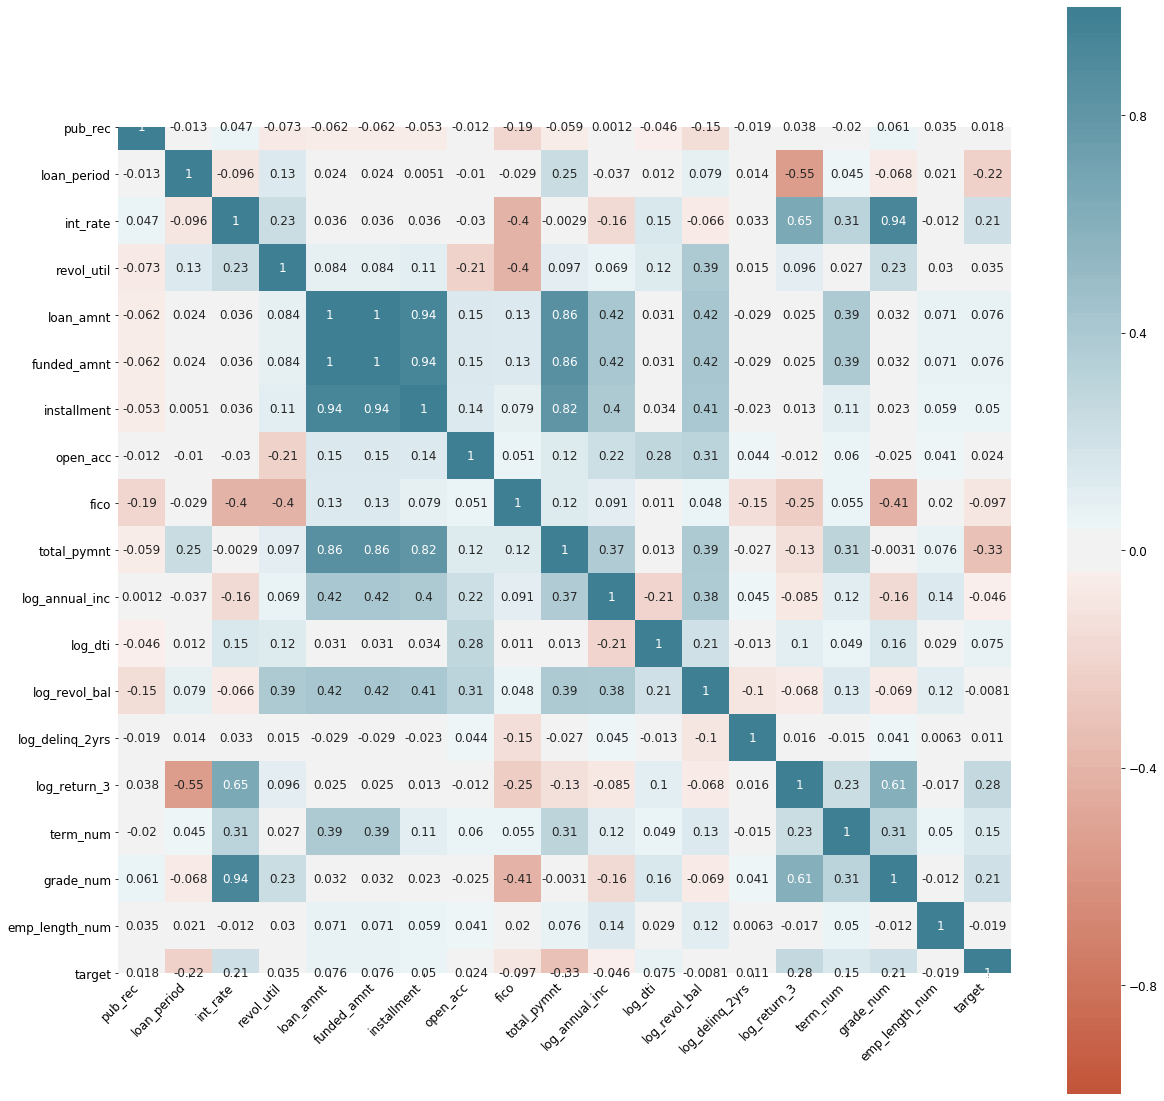

In [109]:
# heatmap

plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 12})

matrix = np.triu(df_CO[list_col_num].corr())

ax = sns.heatmap(
    df_CO[list_col_num].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    #mask=matrix
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Insight**

- Interest rate is highly correlated with loan grade. It makes sense because the loan with lower grade will have higher interest rate.
- Loan amount is highly correlated with funded amount, installment, and total payment.


## Summary

1. What is the percentage of bad loan (default) in this data?
    - Ans: 19.5 %
    
    
2. Which states have higher amound of loan issue?
    - Ans: California, Texas, and New York
    
    
    
3. Which states have higher percentage of bad loan status?
    - Ans: Mississippi, Arkansas, and Alabama 
    
    
    
4. Which attributes are related to the risk of borrower defaults on his/her loan?
    - Ans: grade, term, total payment, interst rate and loan period.
    
    
5. Are those data valuable for investors when they select loans to invest in?
   - Ans: I attemp to use mechine learning to predict the borrower's defaults. So these data will be helpful to guide investors when they select the loans.
    
    
6. Can we estimate the average return an investor expect from the p2p loan?
    - Ans: I atemp to build a model to answer this question. 
    
    